# Exploratory Data Analysis

In this seciton, we will now look at the processed JSON file that we extracted through the Riot API. 

In [1]:
# Imports necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import OneHotEncoder
from matplotlib.lines import Line2D
from sklearn.preprocessing import MinMaxScaler

In [2]:
pickle_filenames = ['data/team_stats.pickle', 'data/player_stats.pickle']

# Create an empty dictionary to hold the loaded dataFrames
dataframes = {}

# Load each pickle file and store the dataFrame in the dictionary
for filename in pickle_filenames:
    with open(filename, 'rb') as f:
        df = pickle.load(f)
        # Extract the DataFrame name from the filename
        df_name = filename.split('.')[0]
        dataframes[df_name] = df

# Creates dataframes
team_df = dataframes['data/team_stats']
player_df = dataframes['data/player_stats']

In [3]:
print(team_df.shape) 
print(player_df.shape)

(16702, 14)
(83510, 11)


Remember that there are two teams, namely red and blue, and ten players for every match. From the shape of the dataframes, we can confirm that we have total of 8351 matches after pre-processing 10 matches per 1000 players in the Master's league.

Let's check the extracted columns and their data types for the team statistics.

In [4]:
print(team_df.columns)
print()
print(team_df.dtypes)

Index(['match_id', 'teamId', 'first_baron', 'first_blood', 'first_dragon',
       'first_inhibitor', 'first_herald', 'first_tower', 'total_baron',
       'total_dragon', 'total_inhibitor', 'total_herald', 'total_tower',
       'win'],
      dtype='object')

match_id           object
teamId             object
first_baron          bool
first_blood          bool
first_dragon         bool
first_inhibitor      bool
first_herald         bool
first_tower          bool
total_baron         int64
total_dragon        int64
total_inhibitor     int64
total_herald        int64
total_tower         int64
win                  bool
dtype: object


Since we do not want to deal with boolean values in our model, we will map them to binary classes: 0 for False and 1 for True. 

In [5]:
# Maps boolean values into 1 or 0
bool_mapping = {
    True: 1, 
    False: 0
}

team_df = team_df.replace(bool_mapping)

In [6]:
team_df.head(2)

,match_id,teamId,first_baron,first_blood,first_dragon,first_inhibitor,first_herald,first_tower,total_baron,total_dragon,total_inhibitor,total_herald,total_tower,win
0,NA1_4698306968,100,1,0,0,1,1,0,2,2,4,2,11,1
1,NA1_4698306968,200,0,1,1,0,0,1,0,3,0,0,3,0


We will do the same for the player statistics.

In [7]:
print(player_df.columns)
print()
print(player_df.dtypes)

Index(['match_id', 'duration', 'position', 'kills', 'deaths', 'assists',
       'gold_earned', 'neutral_minions', 'vision_score', 'lane_minions',
       'win'],
      dtype='object')

match_id           object
duration            int64
position           object
kills               int64
deaths              int64
assists             int64
gold_earned         int64
neutral_minions     int64
vision_score        int64
lane_minions        int64
win                  bool
dtype: object


Remember that duration measures how long the match took to finish. To prevent any outliers from player trolling or not playing the game properly, we will exclude any matches that has duration of less than 10 minutes, which is equivalent to 600 seconds.

In [8]:
threshold = 600
player_df = player_df.replace(bool_mapping)
player_df = player_df[player_df['duration'] > threshold] # Excludes matches below 10 minutes

In [9]:
player_df.head(10)

,match_id,duration,position,kills,deaths,assists,gold_earned,neutral_minions,vision_score,lane_minions,win
0,NA1_4698306968,2035,TOP,3,8,4,14563,24,28,242,1
1,NA1_4698306968,2035,JUNGLE,15,7,15,18760,183,38,36,1
2,NA1_4698306968,2035,MIDDLE,3,7,18,12833,0,18,201,1
3,NA1_4698306968,2035,BOTTOM,16,7,9,19932,39,14,265,1
4,NA1_4698306968,2035,UTILITY,0,7,27,9692,0,111,41,1
5,NA1_4698306968,2035,TOP,7,5,13,13952,4,16,228,0
6,NA1_4698306968,2035,JUNGLE,9,8,8,13240,160,25,37,0
7,NA1_4698306968,2035,MIDDLE,4,5,14,12218,4,20,214,0
8,NA1_4698306968,2035,BOTTOM,14,9,4,17761,8,22,267,0
9,NA1_4698306968,2035,UTILITY,1,10,17,8307,0,71,35,0


Notice that `position` is the only categorical variable here. Let's take a closer look.

In [10]:
player_df['position'].unique()

array(['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY', ''], dtype=object)

We are expecting only five positions, but there is an extra position with empty string.

In [11]:
missing_position = player_df[player_df['position'] == '']
missing_position

,match_id,duration,position,kills,deaths,assists,gold_earned,neutral_minions,vision_score,lane_minions,win
9287,NA1_4700037888,910,,0,1,0,2155,0,0,1,0
37817,NA1_4694479016,637,,0,0,0,1577,0,0,0,0
45975,NA1_4701080675,1394,,0,5,1,4354,0,7,40,0
56354,NA1_4700766322,1210,,0,0,0,3065,0,0,0,0


Fortunately, this issue occured to only few of our matches. We can pick a match and see which position is missing.

In [12]:
match = player_df[player_df['match_id'] == missing_position['match_id'].iloc[0]]
match

,match_id,duration,position,kills,deaths,assists,gold_earned,neutral_minions,vision_score,lane_minions,win
9280,NA1_4700037888,910,TOP,2,3,1,5771,0,9,117,1
9281,NA1_4700037888,910,JUNGLE,2,0,6,6209,100,4,2,1
9282,NA1_4700037888,910,MIDDLE,6,1,0,7398,4,5,131,1
9283,NA1_4700037888,910,BOTTOM,0,2,4,6240,0,3,127,1
9284,NA1_4700037888,910,UTILITY,2,0,7,4914,0,32,6,1
9285,NA1_4700037888,910,TOP,2,5,1,4813,0,3,85,0
9286,NA1_4700037888,910,JUNGLE,1,0,1,5098,90,21,16,0
9287,NA1_4700037888,910,,0,1,0,2155,0,0,1,0
9288,NA1_4700037888,910,BOTTOM,1,4,2,5476,0,10,131,0
9289,NA1_4700037888,910,UTILITY,2,2,0,4574,0,8,58,0


Looks like we are missing the middle position. Since the positions are always in same order, we will fill out the empty position based on the previous position.

In [13]:
positions = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']

for i in range(len(missing_position['match_id'])):
    match = player_df[player_df['match_id'] == missing_position['match_id'].iloc[i]]
    missing_index = match[match['position'] == ''].index[0]
    prev_position = match.loc[missing_index - 1]['position']
    positions_index = positions.index(prev_position)
    player_df.loc[missing_index, 'position'] = positions[(positions_index + 1) % len(positions)]

    player_df = player_df.reset_index(drop=True)

In [14]:
player_df['position'].unique()

array(['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY'], dtype=object)

In [15]:
player_df.head(10)

,match_id,duration,position,kills,deaths,assists,gold_earned,neutral_minions,vision_score,lane_minions,win
0,NA1_4698306968,2035,TOP,3,8,4,14563,24,28,242,1
1,NA1_4698306968,2035,JUNGLE,15,7,15,18760,183,38,36,1
2,NA1_4698306968,2035,MIDDLE,3,7,18,12833,0,18,201,1
3,NA1_4698306968,2035,BOTTOM,16,7,9,19932,39,14,265,1
4,NA1_4698306968,2035,UTILITY,0,7,27,9692,0,111,41,1
5,NA1_4698306968,2035,TOP,7,5,13,13952,4,16,228,0
6,NA1_4698306968,2035,JUNGLE,9,8,8,13240,160,25,37,0
7,NA1_4698306968,2035,MIDDLE,4,5,14,12218,4,20,214,0
8,NA1_4698306968,2035,BOTTOM,14,9,4,17761,8,22,267,0
9,NA1_4698306968,2035,UTILITY,1,10,17,8307,0,71,35,0


In addition, since one of our end goal is to apply the prediction model to real time match data, given that Riot will provide one or at least a delayed one through the spectator mode in the future (currently, the spectator mode API returns a different data), we will scale our numerical variables by minutes, and will also normalize them through `MinMaxScaler()` since features like `gold_earned` have different range of values compared to `kills`.

In [16]:
per_min_features = ['kills', 'deaths', 'assists', 'gold_earned', 'neutral_minions', 'vision_score', 'lane_minions']
norm_features = ['gold_earned', 'neutral_minions', 'vision_score', 'lane_minions']

scaler = MinMaxScaler()

for feature in per_min_features:
    player_df[feature] = player_df[feature] / (player_df['duration'] / 60) # Duration is in seconds

for feature in norm_features:    
    values = player_df[feature].values.reshape(-1, 1)
    scaler.fit(values)
    normed_feature = scaler.transform(values)    
    player_df[feature] = normed_feature
    
player_df.head(10)

,match_id,duration,position,kills,deaths,assists,gold_earned,neutral_minions,vision_score,lane_minions,win
0,NA1_4698306968,2035,TOP,0.088452,0.235872,0.117936,0.368702,0.075915,0.157660,0.628108,1
1,NA1_4698306968,2035,JUNGLE,0.442260,0.206388,0.442260,0.527514,0.578850,0.213968,0.093438,1
2,NA1_4698306968,2035,MIDDLE,0.088452,0.206388,0.530713,0.303240,0.000000,0.101353,0.521693,1
3,NA1_4698306968,2035,BOTTOM,0.471744,0.206388,0.265356,0.571862,0.123361,0.078830,0.687804,1
4,NA1_4698306968,2035,UTILITY,0.000000,0.206388,0.796069,0.184386,0.000000,0.625011,0.106415,1
5,NA1_4698306968,2035,TOP,0.206388,0.147420,0.383292,0.345582,0.012652,0.090092,0.591771,0
6,NA1_4698306968,2035,JUNGLE,0.265356,0.235872,0.235872,0.318640,0.506098,0.140768,0.096033,0
7,NA1_4698306968,2035,MIDDLE,0.117936,0.147420,0.412776,0.279969,0.012652,0.112615,0.555434,0
8,NA1_4698306968,2035,BOTTOM,0.412776,0.265356,0.117936,0.489713,0.025305,0.123876,0.692995,0
9,NA1_4698306968,2035,UTILITY,0.029484,0.294840,0.501229,0.131978,0.000000,0.399782,0.090842,0


We have converted our features by amounts per minute, and also normalized features that have wider range of values.

***
## Team Statistics

Let's examine the features in more details. For the team statistics, we will briefly explain the following:
- `first_baron`: killing a baron gives a strong buff for team fight and lane push
- `first_blood`: first kill of the game, giving 400 golds to the player
- `first_dragon`: killing a dragon also gives a buff, such as % damage increase
- `first_inhibitor`: summons super minions in a lane, giving more pressure and map control through out the game
- `first_herald`: summons a herald to push the tower faster and an easiest way to get the tower plate gold 
- `first_tower`: first tower destroyed in the game, providing additional gold to all the players in the team
- `total_baron`: more baron kills give more team advantage through buffs and gold
- `total_dragon`: more dragon kills enhance champion stats
- `total_inhibitor`: more super minions, meaning more map control and lane pressure
- `total_herald`: more gold and faster tower push; restricted to maximum of two per game
- `total_tower`: more gold and eventually leads to taking the inhibitors and the nexus

In general, more total objective kills and having the first kills give advantages to the team, resulting in a "snowball" effect that gradually increases the probability of winning the game.

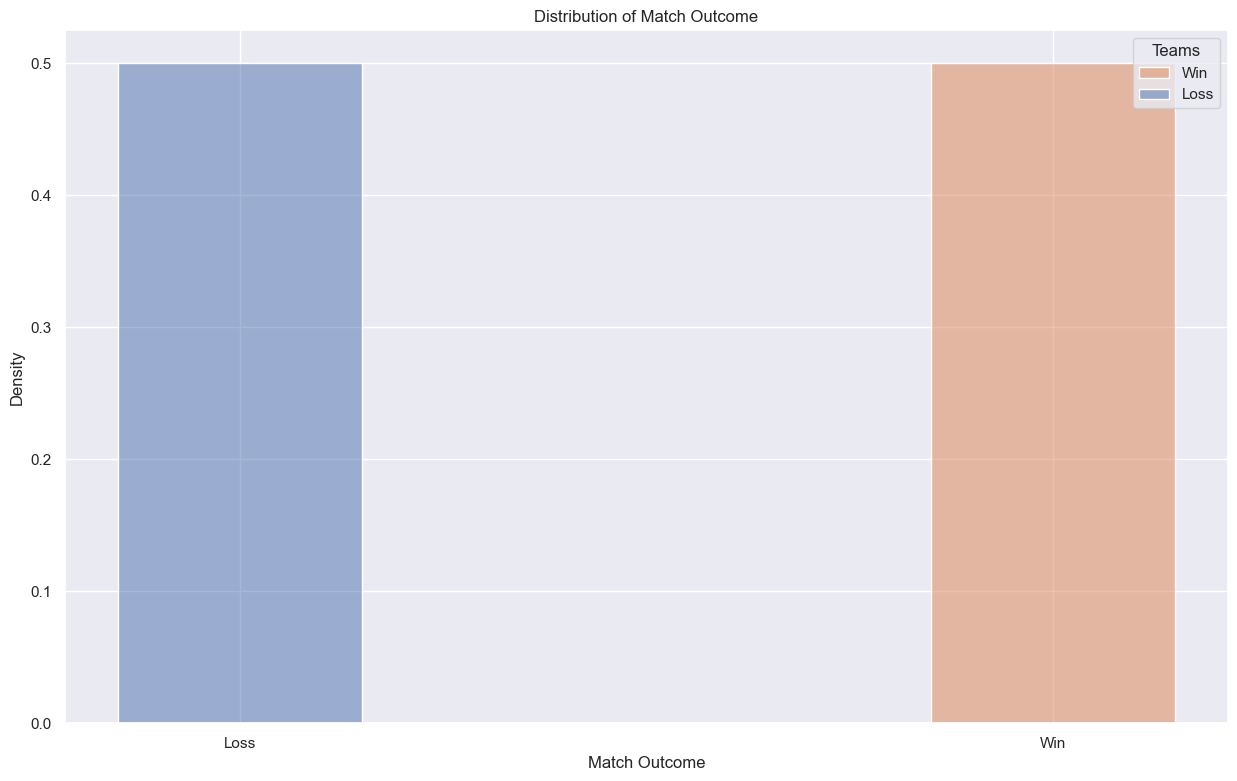

In [17]:
sns.set(style="darkgrid", context="talk", palette="Dark2")
sns.set(rc={"figure.figsize": (15,9)})

ax = sns.histplot(data=team_df, x='win', hue='win', shrink=0.3, stat='density', discrete='True')
ax.set(xlabel="Match Outcome", ylabel="Density", title="Distribution of Match Outcome")
plt.legend(title="Teams", loc="upper right", labels=["Win", "Loss"])
plt.xticks([0, 1], ['Loss', 'Win'])
plt.show()

The balance of win/loss in our data is expected since a match will consist of a winning team and a losing team. Let's have a quick overview of the averages of the win/loss team features.

In [18]:
winning_team_stats = team_df[team_df['win'] == 1]
losing_team_stats = team_df[team_df['win'] == 0]

print('Winning Team Mean Stats:\n\n', winning_team_stats.describe().loc['mean'])
print()
print()
print('Losing Team Mean Stats:\n\n', losing_team_stats.describe().loc['mean'])

Winning Team Mean Stats:

 first_baron        0.593342
first_blood        0.590229
first_dragon       0.634295
first_inhibitor    0.700036
first_herald       0.603521
first_tower        0.705664
total_baron        0.808646
total_dragon       2.385583
total_inhibitor    1.340798
total_herald       1.165130
total_tower        7.667465
win                1.000000
Name: mean, dtype: float64


Losing Team Mean Stats:

 first_baron        0.125494
first_blood        0.404383
first_dragon       0.354568
first_inhibitor    0.062028
first_herald       0.382110
first_tower        0.280565
total_baron        0.185966
total_dragon       0.977847
total_inhibitor    0.129685
total_herald       0.610825
total_tower        2.508682
win                0.000000
Name: mean, dtype: float64


We have relatively big differences in `first_inhibitor`, `total_baron`, and `total_dragon`. The difference in `total_inhibitor` and `total_tower` is self explanatory because destorying the inhibitors and the towers is the pathway to the opposite team's nexus, which is invulnerable unless an inhibitor and the two nexus towers are destroyed. As a result, the winning team is likely to have more inhibitors and towers destroyed.

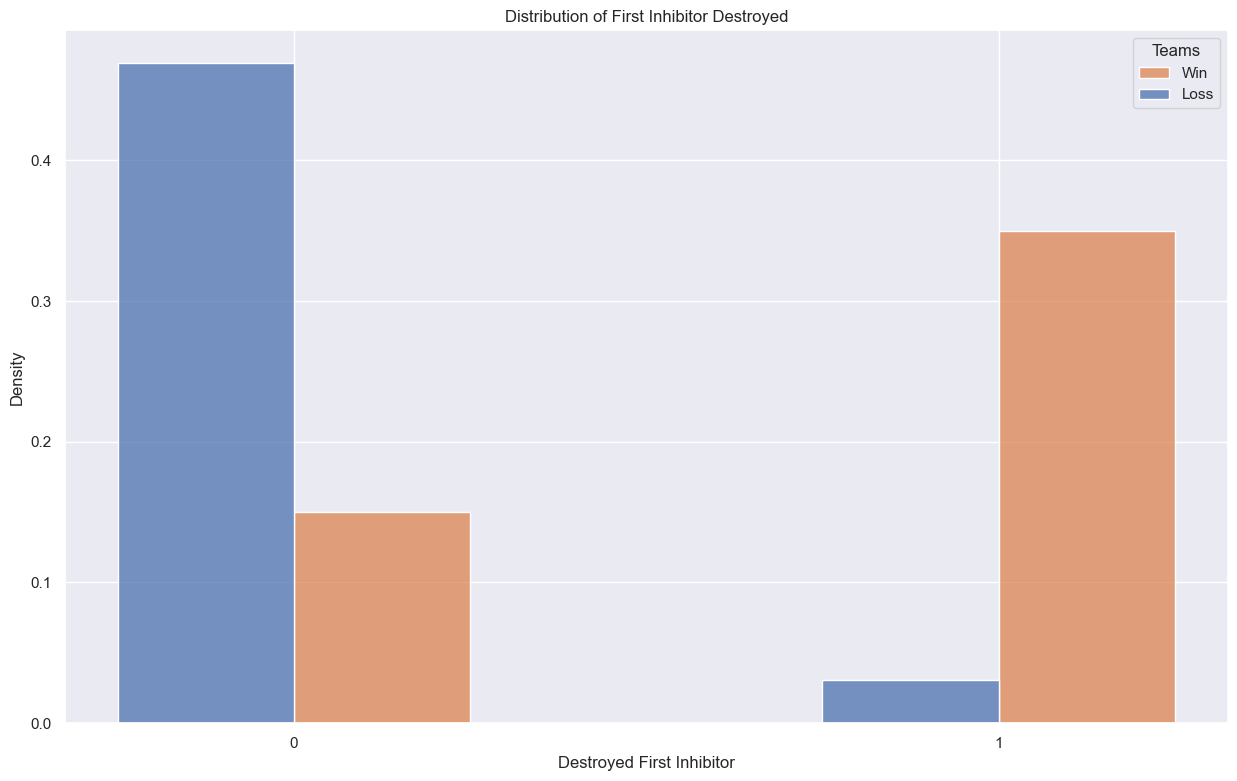

In [19]:
ax = sns.histplot(data=team_df, x='first_inhibitor', hue='win', shrink=0.5, multiple='dodge', stat='density', discrete='True')
ax.set(xlabel="Destroyed First Inhibitor", ylabel="Density", title="Distribution of First Inhibitor Destroyed")
plt.legend(title="Teams", loc="upper right", labels=["Win", "Loss"])
plt.xticks([0, 1])
plt.show()

This is expected since destroying the first inhibitor implies that the team is already ahead of the opposite team. However, depending on the team strategy and champion composition, your team might be "losing" the game, but still able to get the first inhibitor. 

Destroying the first inhibitor is very important because the superminions put pressure on the lane, and if the opposite team is not defending the base for too long, then the superminions will destroy the nexus. Because of this pressure, the opposite team will lose additional objectives, such as baron and dragon, to defend the base, eventually leading to a loss.

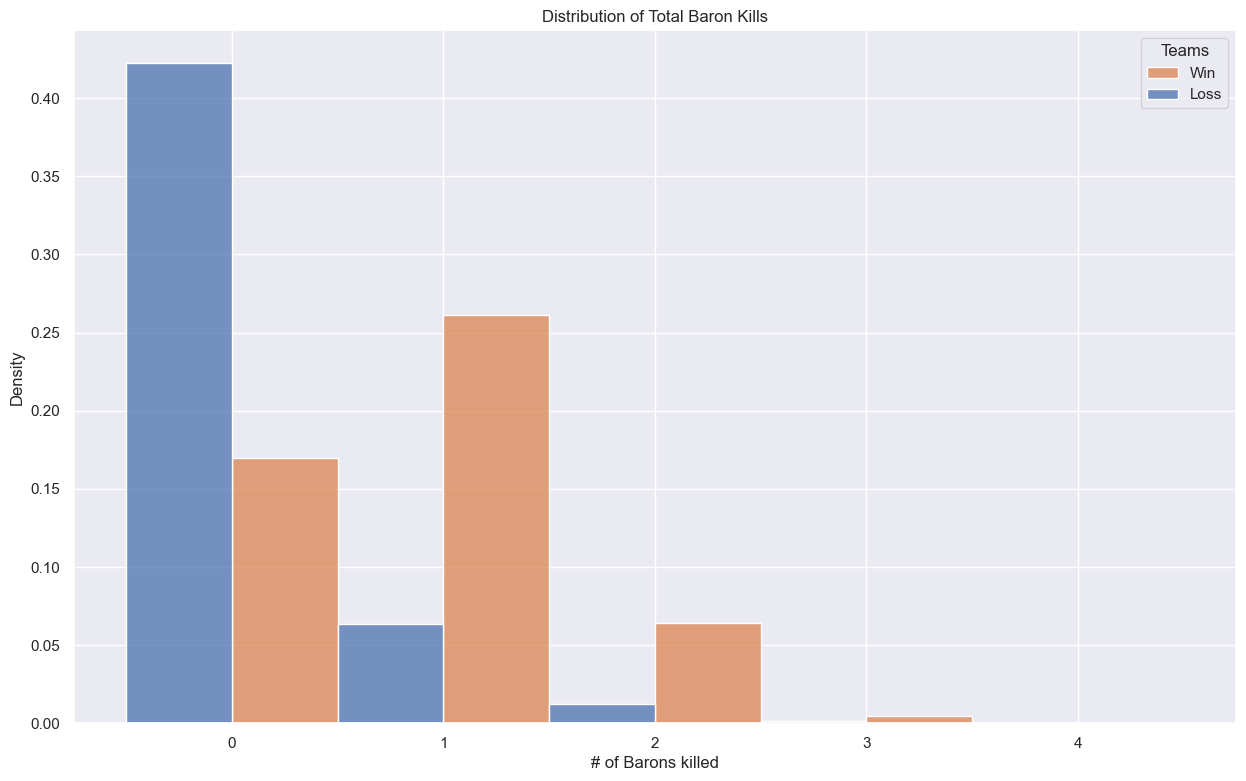

In [20]:
ax = sns.histplot(data=team_df, x='total_baron', hue='win', bins=3, multiple='dodge', stat='density', discrete='True')
ax.set(xlabel="# of Barons killed", ylabel="Density", title="Distribution of Total Baron Kills")
plt.legend(title="Teams", loc="upper right", labels=["Win", "Loss"])

As we predicted in the beginning, more baron kills will lead to victory. This is because in addition to extra gold for each player in the team, the baron buff strongly enhances the minion and the champions will allow the team to take more objectives that is critical to winning the game.

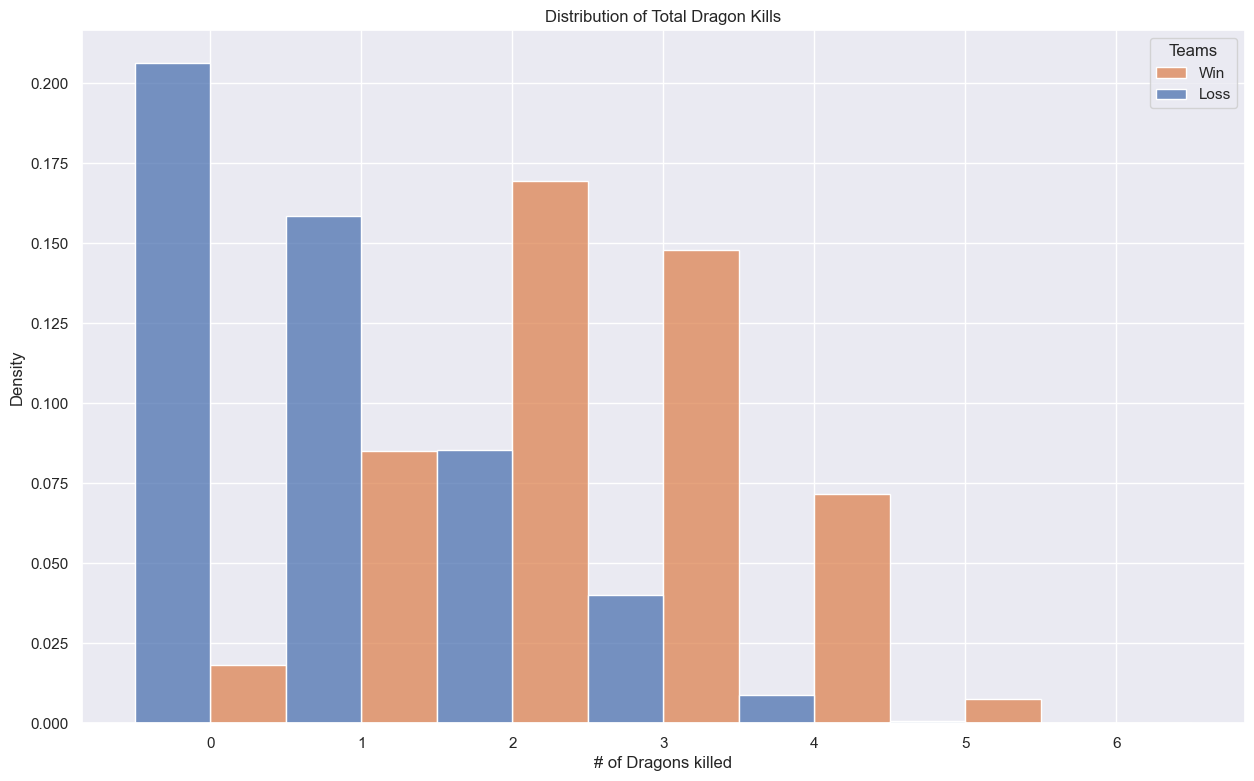

In [21]:
ax = sns.histplot(data=team_df, x='total_dragon', hue='win', bins=3, multiple='dodge', stat='density', discrete='True')
ax.set(xlabel="# of Dragons killed", ylabel="Density", title="Distribution of Total Dragon Kills")
plt.legend(title="Teams", loc="upper right", labels=["Win", "Loss"])

Similar to `total_baron`, more dragon kills lead to winning the game. Although the dragon buff is not a game change, if the buff stacks few time, it does add value to the fights. From the graph, we can see that the losing team had higher density in killing a dragon, but they still lost the game. On contrary, we can see that the winning team had much higher density as number of dragons killed increases. 

Most importantly, first team that kills four dragons receive a powerful buff called "dragon soul" which could easily win the game. Moreover, we see some winning teams killed 5 dragons, and I assume this includes the kill for the elder dragon, which is an attack buff that will execute the enemy champions below certain health percentage, thereby significantly increasing the chance of winning.

We will not engineer another features called `dragon_soul` and `elder_dragon` since I suspect they will be collinear to `total_dragon` as 4 kills and beyond would already imply `dragon_soul` and `elder_dragon`.

***
## Individual Player's Statistics
In addition to the team statistics, we also have each player's statistics in the match:
- `position`: determines which player goes to which lane
- `kills`: enemy champion kill, providing gold to the player
- `death`: player champion's death
- `assists`: assisting other player in the team to kill the enemy champion
- `gold_earned`: total gold earned by the player; can buy items that enhances champion stats 
- `neutral_minions`: minions that can be killed by anyone; usually killed by players in jungle position
- `vision_score`: indicates how much of your team's vision has been influenced by your play
- `lane_minion`: minions in the three lanes that give gold when killed by the player

Similar to the team features, higher numerical values of the individual player's features (other than position and death) should increase the probability of winning the game.

In [22]:
winning_player_stats = player_df[player_df['win'] == 1]
losing_player_stats = player_df[player_df['win'] == 0]

print('Winning Player Mean Per Min Stats:\n\n', winning_player_stats.describe().loc['mean'])
print()
print()
print('Losing Player Mean Per Min Stats:\n\n', losing_player_stats.describe().loc['mean'])

Winning Player Mean Per Min Stats:

 duration           1554.583928
kills                 0.249609
deaths                0.148112
assists               0.363733
gold_earned           0.380839
neutral_minions       0.137353
vision_score          0.185332
lane_minions          0.407985
win                   1.000000
Name: mean, dtype: float64


Losing Player Mean Per Min Stats:

 duration           1554.583928
kills                 0.147274
deaths                0.250235
assists               0.208741
gold_earned           0.280804
neutral_minions       0.109879
vision_score          0.163593
lane_minions          0.384150
win                   0.000000
Name: mean, dtype: float64


It looks like there are not much difference between the winning players and the losing players other than `gold_earned` and `kills`. Let's break it down by positions and see if we can find anything else.

In [23]:
positions = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']

for position in positions:
    winning_position_stats = winning_player_stats[winning_player_stats['position'] == position]
    losing_position_stats = losing_player_stats[losing_player_stats['position'] == position]
    print(f'Winning {position} Player Mean Per Min Stats:\n\n', winning_position_stats.describe().loc['mean'])
    print()
    print()
    print(f'Losing {position} Player Mean Per Min Stats:\n\n', losing_position_stats.describe().loc['mean'])
    print('-' * 50)

Winning TOP Player Mean Per Min Stats:

 duration           1554.583928
kills                 0.223634
deaths                0.150225
assists               0.240642
gold_earned           0.393762
neutral_minions       0.029071
vision_score          0.115425
lane_minions          0.611397
win                   1.000000
Name: mean, dtype: float64


Losing TOP Player Mean Per Min Stats:

 duration           1554.583928
kills                 0.134293
deaths                0.245431
assists               0.136741
gold_earned           0.295141
neutral_minions       0.015935
vision_score          0.104045
lane_minions          0.567001
win                   0.000000
Name: mean, dtype: float64
--------------------------------------------------
Winning JUNGLE Player Mean Per Min Stats:

 duration           1554.583928
kills                 0.328111
deaths                0.135040
assists               0.366374
gold_earned           0.435666
neutral_minions       0.593360
vision_score          0.

The average statistics by positions show us relatively significant difference in certain variables in specific positions. For example, winning players in the bottom lane (on average) have almost twice more kills than the opponent player in the same lane. Similarly, the winning players in utility (or really called "support" in-game) have lot more assists. The difference in `gold_earned` is prominent in all positions, which would probably be the more important feature. On contrary, the difference in `lane_minions` is not as big as I expected, and this could be explained by the fact that our match data is from the Master's league, where every player is very good at killing every single minion.

Let's take a look at the players at specific positions.

In [24]:
bottom = player_df[player_df['position'] == 'BOTTOM']

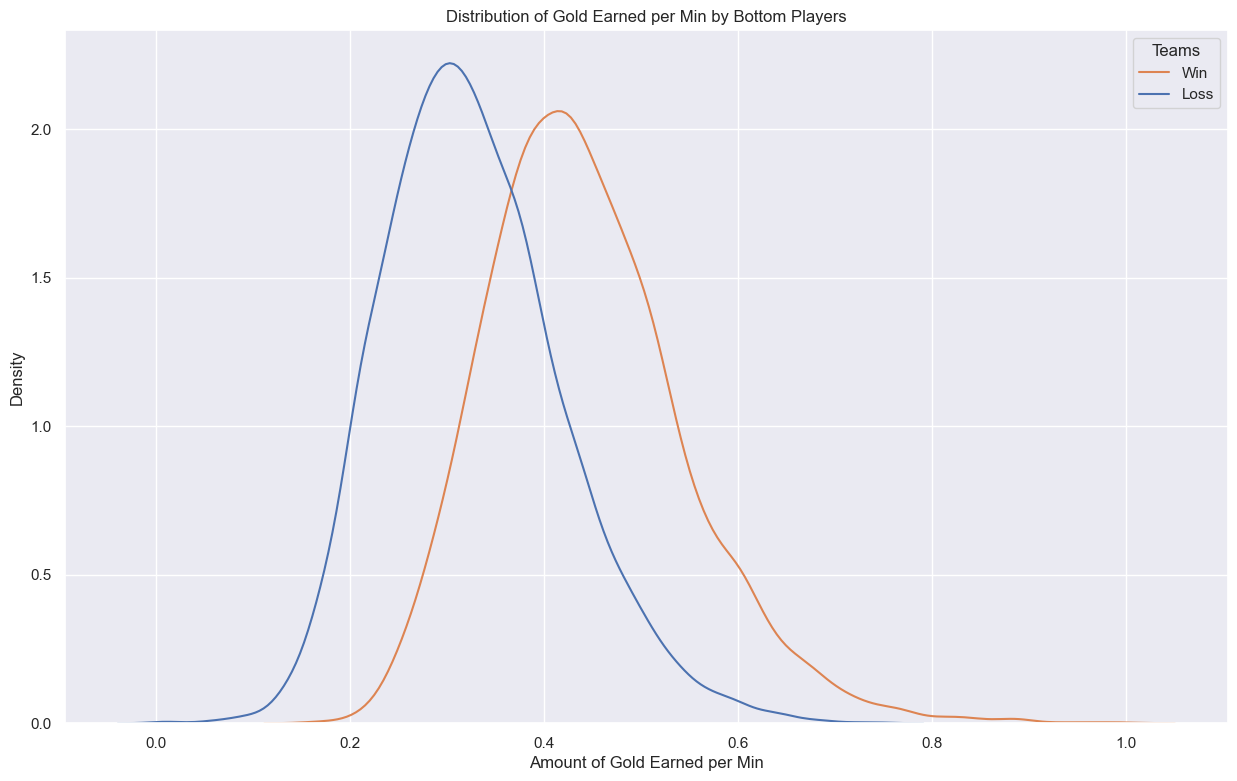

In [25]:
ax = sns.kdeplot(data=bottom, x='gold_earned', hue='win')
ax.set(xlabel="Amount of Gold Earned per Min", ylabel="Density", title="Distribution of Gold Earned per Min by Bottom Players")
plt.legend(title="Teams", loc="upper right", labels=["Win", "Loss"])
plt.show()

The distribution looks similar, but as we expected, the winning bottom player had more gold than the losing player. Bottom players usually play ranged attack damage champions (ADCs), which become very powerful as they buy items with gold (they "carry" the game). Therefore, having higher amount of gold could be a good predictor of winning the game.

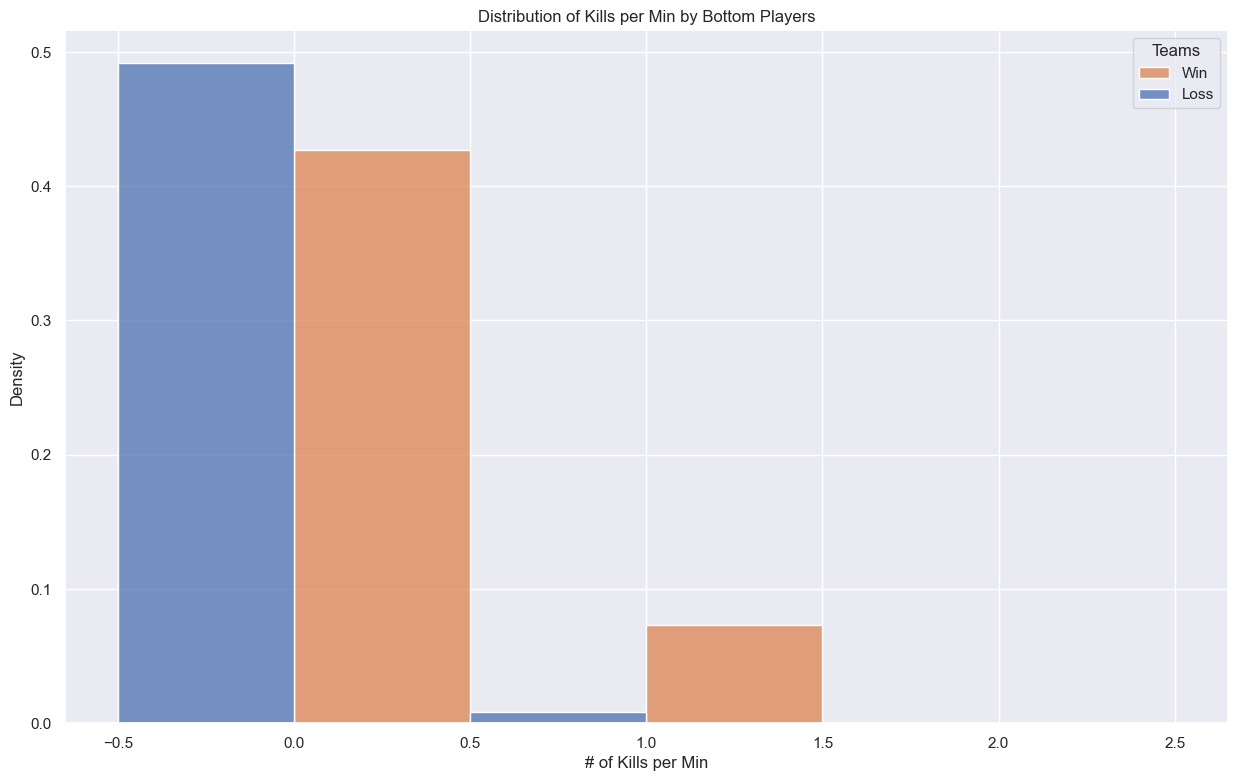

In [26]:
ax = sns.histplot(data=bottom, x='kills', hue='win', multiple='dodge', stat='density', discrete='True')
ax.set(xlabel="# of Kills per Min", ylabel="Density", title="Distribution of Kills per Min by Bottom Players")
plt.legend(title="Teams", loc="upper right", labels=["Win", "Loss"])

The distribution of kills for the losing bottom players is bit more left tailed. In a higher ranked games like in the Master's league, kills do not occur as frequently as the games in the lower ranked games because all the players try not to die as much as possible. As a result, the snowball effect plays more significant role, meaning the player with initial kill advantage tends to have more kills as the game progress. Hence, getting two or three kills in the beginning of the game could be a good predictor of deciding the winner, especially for the bottom players.

In [27]:
jungle = player_df[player_df['position'] == 'JUNGLE']

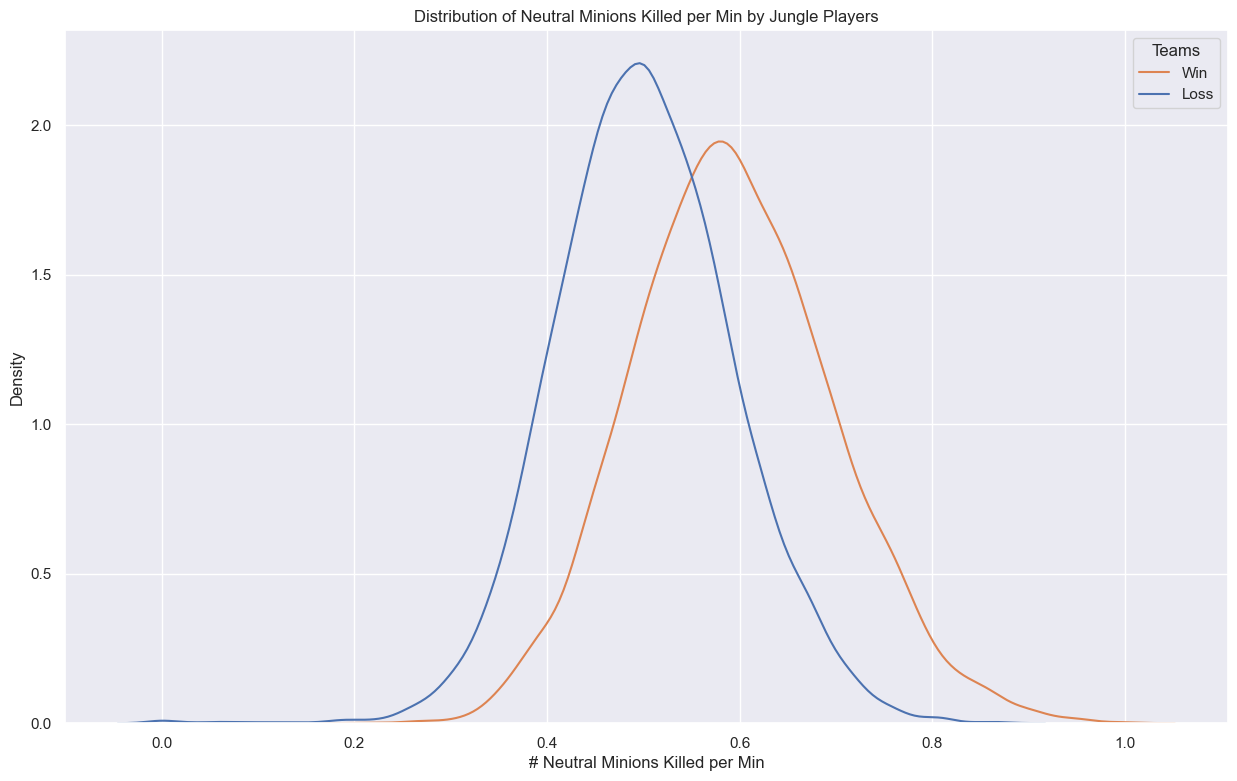

In [28]:
ax = sns.kdeplot(data=jungle, x='neutral_minions', hue='win')
ax.set(xlabel="# Neutral Minions Killed per Min", ylabel="Density", title="Distribution of Neutral Minions Killed per Min by Jungle Players")
plt.legend(title="Teams", loc="upper right", labels=["Win", "Loss"])
plt.show()

Jungle is a special position since they do not go to one of the three lanes. Instead, the champions go to a neutral areas (aka "jungle") in the map, and they level up and earn gold by killing the minions in that specific area. killing more `lane_minions` only implies having more gold, but killing more `neutral_minions` also implies map control since the jungle position with higher neutral minion kills probably "invaded" the enemy jungle to kill more neutral minions. This kind of play tends to result in more objective and champion kills, eventually leading the team to victory.

In [29]:
utility = player_df[player_df['position'] == 'UTILITY']

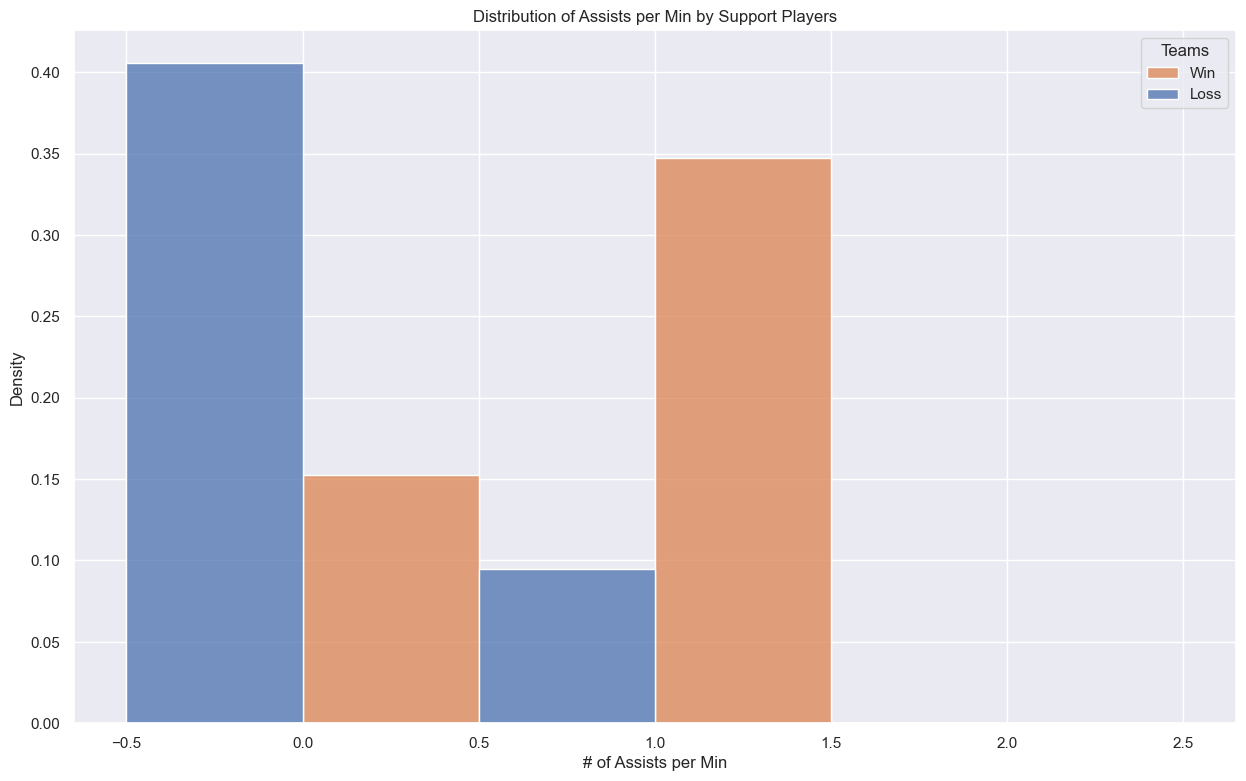

In [30]:
ax = sns.histplot(data=utility, x='assists', hue='win', multiple='dodge', stat='density', discrete='True')
ax.set(xlabel="# of Assists per Min", ylabel="Density", title="Distribution of Assists per Min by Support Players")
plt.legend(title="Teams", loc="upper right", labels=["Win", "Loss"])

The distribution of assists from the losing support players is lot more left tailed. The utility players "support" the bottom players to harass and kill the enemy support and bottom players. They could play defensive champions to protect or heal the ranged champions, or could also play aggressive champions to get more kills and deny the enemy from killing the `lane_minions`. Additionally, they tend to "roam" to the other lane, such top or middle, for objectives or assisting in champion kills. Hence, the number of assists shows how the support players influenced the game.

We analyzed some of the match features that could be good predictors of winning the game. We will now merge the team and individual player's statistics to train our win prediction model. 

***
## Team and Player Statistics

Before we train our prediction model, we will merge the team statistics with the player statistics, using `match_id` and `win` to correctly identify the winning `teamId`. Then, we will take a look at the correlation among the numerical features to observe any collinearity among our independent variables. 

In [31]:
# Merge two dataframes into one for features
match_data = pd.merge(team_df, player_df, on=['match_id', 'win'])
match_data.head(10)

,match_id,teamId,first_baron,first_blood,first_dragon,first_inhibitor,first_herald,first_tower,total_baron,total_dragon,...,win,duration,position,kills,deaths,assists,gold_earned,neutral_minions,vision_score,lane_minions
0,NA1_4698306968,100,1,0,0,1,1,0,2,2,...,1,2035,TOP,0.088452,0.235872,0.117936,0.368702,0.075915,0.157660,0.628108
1,NA1_4698306968,100,1,0,0,1,1,0,2,2,...,1,2035,JUNGLE,0.442260,0.206388,0.442260,0.527514,0.578850,0.213968,0.093438
2,NA1_4698306968,100,1,0,0,1,1,0,2,2,...,1,2035,MIDDLE,0.088452,0.206388,0.530713,0.303240,0.000000,0.101353,0.521693
3,NA1_4698306968,100,1,0,0,1,1,0,2,2,...,1,2035,BOTTOM,0.471744,0.206388,0.265356,0.571862,0.123361,0.078830,0.687804
4,NA1_4698306968,100,1,0,0,1,1,0,2,2,...,1,2035,UTILITY,0.000000,0.206388,0.796069,0.184386,0.000000,0.625011,0.106415
5,NA1_4698306968,200,0,1,1,0,0,1,0,3,...,0,2035,TOP,0.206388,0.147420,0.383292,0.345582,0.012652,0.090092,0.591771
6,NA1_4698306968,200,0,1,1,0,0,1,0,3,...,0,2035,JUNGLE,0.265356,0.235872,0.235872,0.318640,0.506098,0.140768,0.096033
7,NA1_4698306968,200,0,1,1,0,0,1,0,3,...,0,2035,MIDDLE,0.117936,0.147420,0.412776,0.279969,0.012652,0.112615,0.555434
8,NA1_4698306968,200,0,1,1,0,0,1,0,3,...,0,2035,BOTTOM,0.412776,0.265356,0.117936,0.489713,0.025305,0.123876,0.692995
9,NA1_4698306968,200,0,1,1,0,0,1,0,3,...,0,2035,UTILITY,0.029484,0.294840,0.501229,0.131978,0.000000,0.399782,0.090842


Furthermore, we will assume `100` as blue team and `200` as red team.

In [32]:
match_data.replace(to_replace={'100' : 'blue', '200' : 'red'}, inplace=True)
match_data.head(10)

,match_id,teamId,first_baron,first_blood,first_dragon,first_inhibitor,first_herald,first_tower,total_baron,total_dragon,...,win,duration,position,kills,deaths,assists,gold_earned,neutral_minions,vision_score,lane_minions
0,NA1_4698306968,blue,1,0,0,1,1,0,2,2,...,1,2035,TOP,0.088452,0.235872,0.117936,0.368702,0.075915,0.157660,0.628108
1,NA1_4698306968,blue,1,0,0,1,1,0,2,2,...,1,2035,JUNGLE,0.442260,0.206388,0.442260,0.527514,0.578850,0.213968,0.093438
2,NA1_4698306968,blue,1,0,0,1,1,0,2,2,...,1,2035,MIDDLE,0.088452,0.206388,0.530713,0.303240,0.000000,0.101353,0.521693
3,NA1_4698306968,blue,1,0,0,1,1,0,2,2,...,1,2035,BOTTOM,0.471744,0.206388,0.265356,0.571862,0.123361,0.078830,0.687804
4,NA1_4698306968,blue,1,0,0,1,1,0,2,2,...,1,2035,UTILITY,0.000000,0.206388,0.796069,0.184386,0.000000,0.625011,0.106415
5,NA1_4698306968,red,0,1,1,0,0,1,0,3,...,0,2035,TOP,0.206388,0.147420,0.383292,0.345582,0.012652,0.090092,0.591771
6,NA1_4698306968,red,0,1,1,0,0,1,0,3,...,0,2035,JUNGLE,0.265356,0.235872,0.235872,0.318640,0.506098,0.140768,0.096033
7,NA1_4698306968,red,0,1,1,0,0,1,0,3,...,0,2035,MIDDLE,0.117936,0.147420,0.412776,0.279969,0.012652,0.112615,0.555434
8,NA1_4698306968,red,0,1,1,0,0,1,0,3,...,0,2035,BOTTOM,0.412776,0.265356,0.117936,0.489713,0.025305,0.123876,0.692995
9,NA1_4698306968,red,0,1,1,0,0,1,0,3,...,0,2035,UTILITY,0.029484,0.294840,0.501229,0.131978,0.000000,0.399782,0.090842


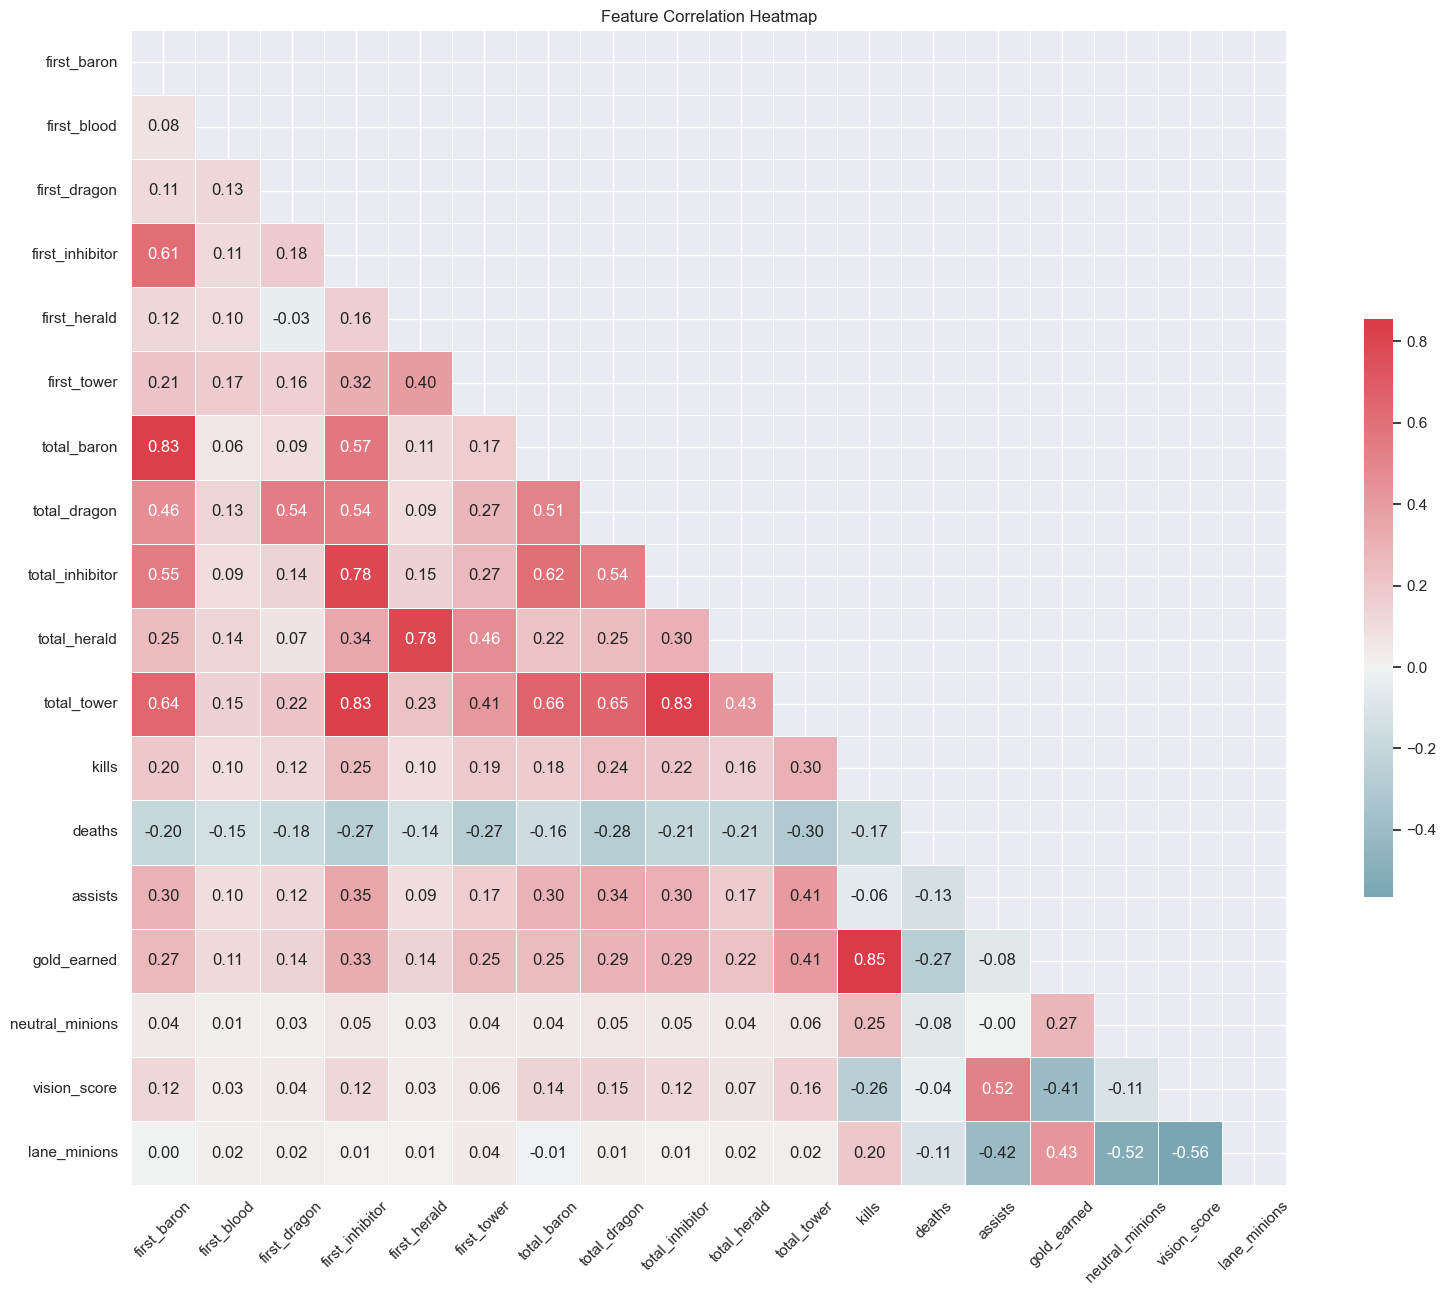

In [33]:
drop_columns = ['match_id', 'teamId', 'position', 'win', 'duration']
selected_features = match_data.drop(columns=drop_columns)

# Compute the correlation matrix
correlation_matrix = selected_features.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

fig, ax = plt.subplots(figsize=(20, 15))

sns.heatmap(
    correlation_matrix, 
    mask=mask, 
    cmap=cmap, 
    center=0, 
    annot=True, 
    fmt=".2f", 
    square=True, 
    linewidths=.5, 
    cbar_kws={"shrink": .5}
)

plt.title("Feature Correlation Heatmap")
plt.xticks(rotation=45)
plt.show()

It seems like the snowball effect, where a small advantage causes significant advantage later on, plays an important role here. Objectives taken first is highly correlated with the total objectives taken (i.e. `first_baron` and `total_baron`), and `gold_earned` is also highly correlated with `kills` since getting a champion kills grants 300 gold. 

Because the correlation coefficients for most of `total` features are near or little over 0.8, we could have some collinearity problem later on. In addition, since the eventual goal of our model is to predict win rate live/delayed time, then these features will likely to cause an overfit because it is very unlikely to capture these "objectives" early game. For example, it will be almost impossible to kill all 4 dragons before 15 minutes. As a result, we will remove them for now, and can always revisit if we have any issues.

In [34]:
drop_columns = ['total_baron', 'total_dragon', 'total_inhibitor', 'total_herald', 'total_tower']
match_data.drop(columns=drop_columns, inplace=True)

***
##  Reshaping the Data

Currently, the data have 10 players in each ranked match, broken down by teams (blue and red) and by the lane positions. The shape of the data could cause a problem with training the prediction model, and consequently, we will reshape the data to change the structure/dimensions of the input data before feeding it into the prediction model. In general, we will "flatten" our dataframe by transforming the match features by team and by position.

In [35]:
position_match = match_data.copy()

# Create new columns for the stats by team and position to uniquely identify each row
position_match['position_stats'] = position_match['teamId'] + '_' + position_match['position']

position_data = position_match.pivot_table(
    index='match_id',
    columns='position_stats',
    values=['kills', 'deaths', 'assists', 'gold_earned', 'neutral_minions', 'vision_score', 'lane_minions'],
    aggfunc='first'
)

# Flatten the multi-level column index
position_data.columns = [f'{pos.lower()}_{col}' for col, pos in position_data.columns]
position_data.reset_index(inplace=True) 
position_data.head(5)

,match_id,blue_bottom_assists,blue_jungle_assists,blue_middle_assists,blue_top_assists,blue_utility_assists,red_bottom_assists,red_jungle_assists,red_middle_assists,red_top_assists,...,blue_bottom_vision_score,blue_jungle_vision_score,blue_middle_vision_score,blue_top_vision_score,blue_utility_vision_score,red_bottom_vision_score,red_jungle_vision_score,red_middle_vision_score,red_top_vision_score,red_utility_vision_score
0,NA1_4635230277,0.137489,0.247479,0.219982,0.164986,0.192484,0.247479,0.329973,0.219982,0.192484,...,0.105028,0.320335,0.189050,0.194301,0.493631,0.183799,0.131285,0.126033,0.110279,0.483128
1,NA1_4649504526,0.289575,0.260618,0.231660,0.202703,0.405405,0.376448,0.260618,0.086873,0.202703,...,0.143785,0.171436,0.143785,0.116134,0.525367,0.149315,0.243328,0.143785,0.105073,0.514307
2,NA1_4649537869,0.105696,0.070464,0.105696,0.035232,0.317087,0.035232,0.387551,0.105696,0.352319,...,0.121112,0.161483,0.121112,0.087470,0.417163,0.053828,0.208582,0.148026,0.134569,0.410435
3,NA1_4650646767,0.205597,0.205597,0.342661,0.137065,0.513992,0.205597,0.342661,0.137065,0.034266,...,0.130880,0.196320,0.117792,0.170144,0.490800,0.150512,0.346832,0.091616,0.130880,0.340288
4,NA1_4652371296,0.218579,0.291439,0.255009,0.400729,0.582878,0.109290,0.072860,0.072860,0.072860,...,0.173930,0.132187,0.271331,0.153059,0.493962,0.083487,0.034786,0.132187,0.187845,0.438305


In [36]:
team_match = match_data.copy()

team_match['team_stats'] = team_match['teamId']

team_data = team_match.pivot_table(
    index='match_id',
    columns='team_stats',
    values=['first_baron', 'first_blood', 'first_dragon', 'first_inhibitor', 'first_herald', 'first_tower',],
    aggfunc='first'
)

team_data.columns = [f'{pos.lower()}_{col}' for col, pos in team_data.columns]
team_data.reset_index(inplace=True) 
team_data.head(5)

,match_id,blue_first_baron,red_first_baron,blue_first_blood,red_first_blood,blue_first_dragon,red_first_dragon,blue_first_herald,red_first_herald,blue_first_inhibitor,red_first_inhibitor,blue_first_tower,red_first_tower
0,NA1_4635230277,0,1,0,1,0,1,1,0,0,1,1,0
1,NA1_4649504526,0,1,0,1,1,0,0,1,0,1,0,1
2,NA1_4649537869,0,1,1,0,0,1,1,0,0,1,1,0
3,NA1_4650646767,1,0,0,1,1,0,1,0,1,0,1,0
4,NA1_4652371296,1,0,1,0,1,0,1,0,1,0,1,0


In [37]:
won_match = match_data.copy()

won_match['team_won'] = won_match['teamId']

winning_team = won_match.pivot_table(
    index='match_id',
    columns='team_won',
    values=['win'],
    aggfunc='first'
)

winning_team.columns = [f'{pos.lower()}_{col}' for col, pos in winning_team.columns]
winning_team.reset_index(inplace=True)
winning_team.head(5)

,match_id,blue_win,red_win
0,NA1_4635230277,0,1
1,NA1_4649504526,0,1
2,NA1_4649537869,0,1
3,NA1_4650646767,1,0
4,NA1_4652371296,1,0


In [38]:
merged_data = pd.merge(position_data, team_data, on='match_id').merge(winning_team, on='match_id')
merged_data.head(5)

,match_id,blue_bottom_assists,blue_jungle_assists,blue_middle_assists,blue_top_assists,blue_utility_assists,red_bottom_assists,red_jungle_assists,red_middle_assists,red_top_assists,...,blue_first_dragon,red_first_dragon,blue_first_herald,red_first_herald,blue_first_inhibitor,red_first_inhibitor,blue_first_tower,red_first_tower,blue_win,red_win
0,NA1_4635230277,0.137489,0.247479,0.219982,0.164986,0.192484,0.247479,0.329973,0.219982,0.192484,...,0,1,1,0,0,1,1,0,0,1
1,NA1_4649504526,0.289575,0.260618,0.231660,0.202703,0.405405,0.376448,0.260618,0.086873,0.202703,...,1,0,0,1,0,1,0,1,0,1
2,NA1_4649537869,0.105696,0.070464,0.105696,0.035232,0.317087,0.035232,0.387551,0.105696,0.352319,...,0,1,1,0,0,1,1,0,0,1
3,NA1_4650646767,0.205597,0.205597,0.342661,0.137065,0.513992,0.205597,0.342661,0.137065,0.034266,...,1,0,1,0,1,0,1,0,1,0
4,NA1_4652371296,0.218579,0.291439,0.255009,0.400729,0.582878,0.109290,0.072860,0.072860,0.072860,...,1,0,1,0,1,0,1,0,1,0


In a League of Legends match, only one team can emerge as the winner, making the outcomes mutually exclusive. Therefore, it is sufficient to predict the probability of the blue team (or the red team) winning the game.

In [39]:
one_team = merged_data.copy()
final_data = one_team.filter(like='blue', axis=1) # Either blue team or red team features
final_data.head(5)

,blue_bottom_assists,blue_jungle_assists,blue_middle_assists,blue_top_assists,blue_utility_assists,blue_bottom_deaths,blue_jungle_deaths,blue_middle_deaths,blue_top_deaths,blue_utility_deaths,...,blue_middle_vision_score,blue_top_vision_score,blue_utility_vision_score,blue_first_baron,blue_first_blood,blue_first_dragon,blue_first_herald,blue_first_inhibitor,blue_first_tower,blue_win
0,0.137489,0.247479,0.219982,0.164986,0.192484,0.137489,0.164986,0.274977,0.192484,0.192484,...,0.189050,0.194301,0.493631,0,0,0,1,0,1,0
1,0.289575,0.260618,0.231660,0.202703,0.405405,0.173745,0.318533,0.173745,0.405405,0.231660,...,0.143785,0.116134,0.525367,0,0,1,0,0,0,0
2,0.105696,0.070464,0.105696,0.035232,0.317087,0.211392,0.281856,0.105696,0.422783,0.317087,...,0.121112,0.087470,0.417163,0,1,0,1,0,1,0
3,0.205597,0.205597,0.342661,0.137065,0.513992,0.205597,0.137065,0.137065,0.034266,0.102798,...,0.117792,0.170144,0.490800,1,0,1,1,1,1,1
4,0.218579,0.291439,0.255009,0.400729,0.582878,0.182149,0.072860,0.072860,0.182149,0.109290,...,0.271331,0.153059,0.493962,1,1,1,1,1,1,1


In [40]:
final_data.columns

Index(['blue_bottom_assists', 'blue_jungle_assists', 'blue_middle_assists',
       'blue_top_assists', 'blue_utility_assists', 'blue_bottom_deaths',
       'blue_jungle_deaths', 'blue_middle_deaths', 'blue_top_deaths',
       'blue_utility_deaths', 'blue_bottom_gold_earned',
       'blue_jungle_gold_earned', 'blue_middle_gold_earned',
       'blue_top_gold_earned', 'blue_utility_gold_earned', 'blue_bottom_kills',
       'blue_jungle_kills', 'blue_middle_kills', 'blue_top_kills',
       'blue_utility_kills', 'blue_bottom_lane_minions',
       'blue_jungle_lane_minions', 'blue_middle_lane_minions',
       'blue_top_lane_minions', 'blue_utility_lane_minions',
       'blue_bottom_neutral_minions', 'blue_jungle_neutral_minions',
       'blue_middle_neutral_minions', 'blue_top_neutral_minions',
       'blue_utility_neutral_minions', 'blue_bottom_vision_score',
       'blue_jungle_vision_score', 'blue_middle_vision_score',
       'blue_top_vision_score', 'blue_utility_vision_score',
       'b

In [41]:
final_data.to_pickle('data/final_data.pkl')